In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data=pd.read_csv('airline_passengers.csv')
data

,Month,Thousands of Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0
...,...,...
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [3]:
data.dtypes

Month                       object
Thousands of Passengers    float64
dtype: object

In [4]:
data.isna().sum()

Month                      0
Thousands of Passengers    1
dtype: int64

In [5]:
data=data.dropna(axis=0)

In [6]:
data['Month']=pd.to_datetime(data['Month'])

In [7]:
data.isna().sum()

Month                      0
Thousands of Passengers    0
dtype: int64

In [8]:
data.shape

(144, 2)

<AxesSubplot:>

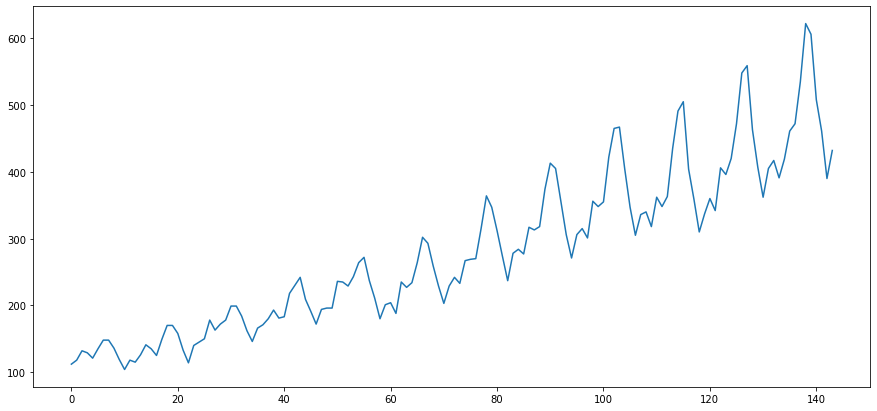

In [9]:
data['Thousands of Passengers'].plot(figsize=(15,7))

## SIMPLE MOVING AVEARAGE

In [10]:
data['30_sma']=data['Thousands of Passengers'].rolling(30).mean()

<AxesSubplot:>

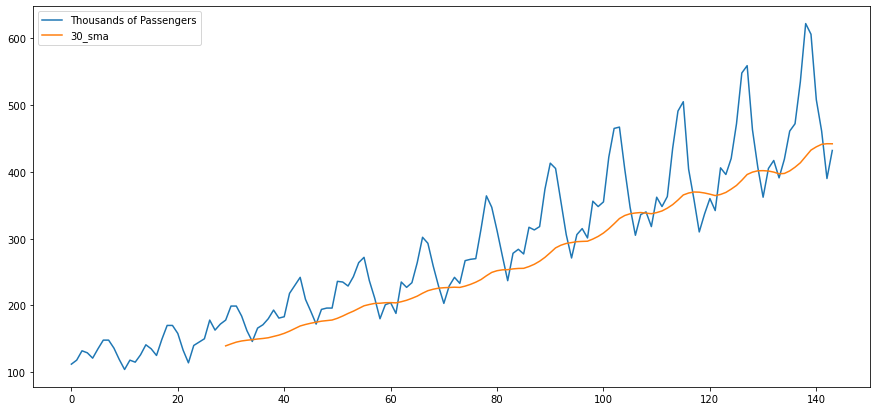

In [11]:
data[['Thousands of Passengers','30_sma']].plot(figsize=(15,7))

## Cumulitive Moving Average


In [12]:
data['cma']=data['Thousands of Passengers'].expanding(min_periods=30).mean()

<AxesSubplot:>

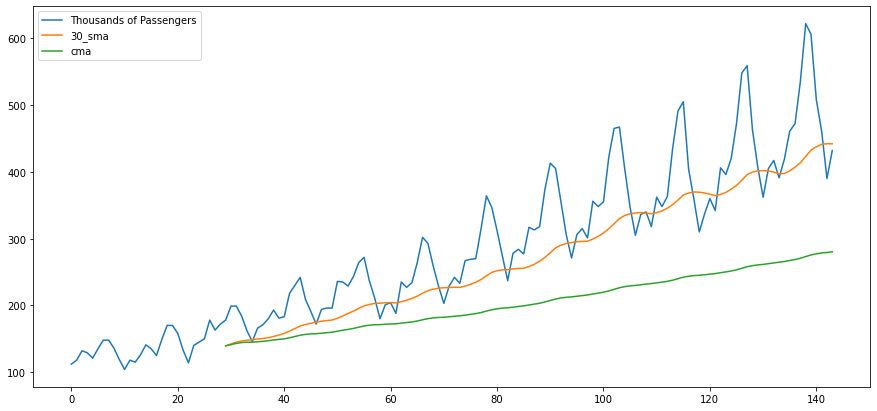

In [13]:
data[['Thousands of Passengers','30_sma','cma']].plot(figsize=(15,7))

## EXPONENTIAL AVERAGE


In [14]:
data['ema']=(data['Thousands of Passengers']).ewm(alpha=0.1, adjust=False).mean()

<AxesSubplot:>

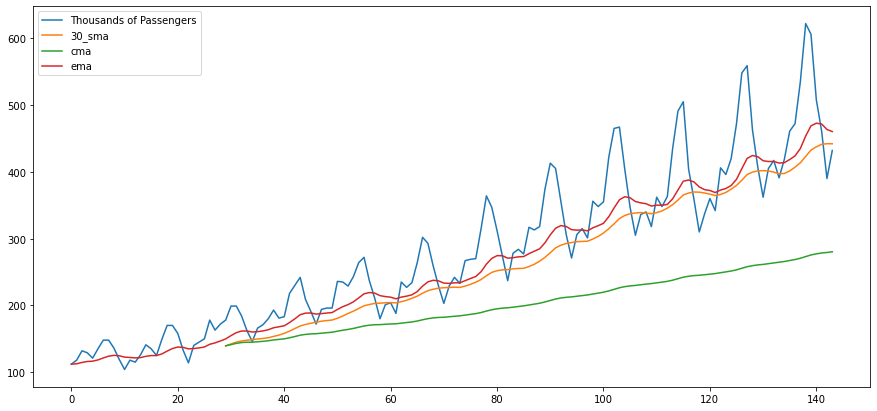

In [15]:
data[['Thousands of Passengers','30_sma','cma','ema']].plot(figsize=(15,7))

## Exponential Weighted Moving Average


In [16]:

data['ewma']=(data['Thousands of Passengers']).ewm(span=30, adjust=False).mean()

<AxesSubplot:>

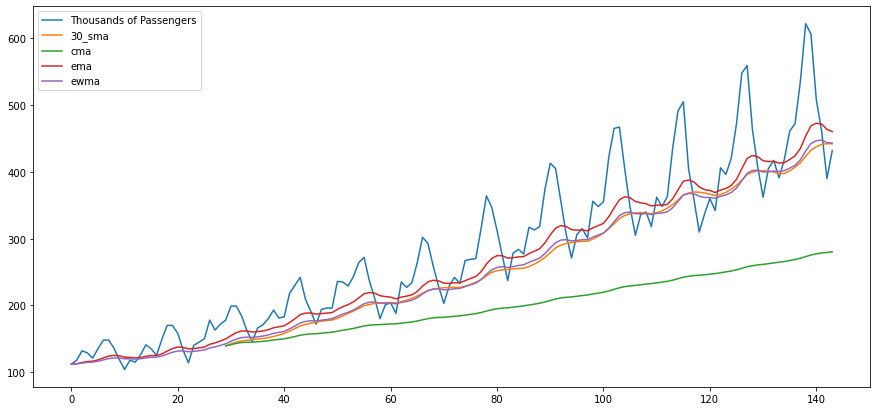

In [17]:
data[['Thousands of Passengers','30_sma','cma','ema','ewma']].plot(figsize=(15,7))

## ADFULLER Test

In [18]:
from statsmodels.tsa.stattools import adfuller

In [19]:
def adfuller_test(series):
    result=adfuller(series)
    print('ADF TEST',result[0])
    print('P VALUE',result[1])
    if result[1]<0.05:
        print('data is stationary')
    else:
        print('data is not stationary')

In [20]:
adfuller_test(data['Thousands of Passengers'])

ADF TEST 0.8153688792060482
P VALUE 0.991880243437641
data is not stationary


In [21]:
data['1st_difference']=data['Thousands of Passengers']-data['Thousands of Passengers'].shift(1)

In [22]:
data.head()

,Month,Thousands of Passengers,30_sma,cma,ema,ewma,1st_difference
0,1949-01-01,112.0,NaN,NaN,112.0000,112.000000,NaN
1,1949-02-01,118.0,NaN,NaN,112.6000,112.387097,6.0
2,1949-03-01,132.0,NaN,NaN,114.5400,113.652445,14.0
3,1949-04-01,129.0,NaN,NaN,115.9860,114.642610,-3.0
4,1949-05-01,121.0,NaN,NaN,116.4874,115.052764,-8.0


## 1ST DIFFERNCE

In [23]:
adfuller_test(data['1st_difference'].dropna())

ADF TEST -2.8292668241699994
P VALUE 0.0542132902838255
data is not stationary


## 2ND DIFFERNCE


In [24]:

data['2st_difference']=data['1st_difference']-data['1st_difference'].shift(1)

In [25]:
adfuller_test(data['2st_difference'].dropna())

ADF TEST -16.384231542468505
P VALUE 2.7328918500142407e-29
data is stationary


## 12th DIFFERNCE

In [26]:


data['12_Difference']=data['Thousands of Passengers']-data['Thousands of Passengers'].shift(12)

In [27]:
adfuller_test(data['12_Difference'].dropna())

ADF TEST -3.383020726492481
P VALUE 0.011551493085514952
data is stationary


Text(0.5, 1.0, '2nd_difference')

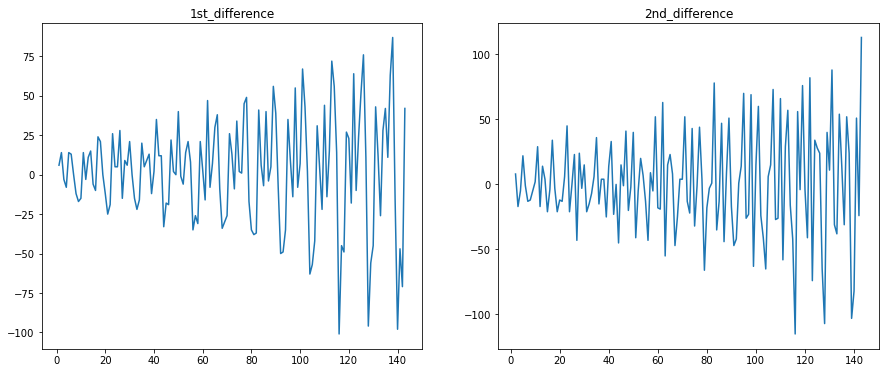

In [28]:
fig, ax=plt.subplots(1,2,figsize=(15,6))
ax[0].plot(data['1st_difference'])
ax[0].set_title('1st_difference')

ax[1].plot(data['2st_difference'])
ax[1].set_title('2nd_difference')

## Auto correaltion, Partial Auto correaltion

In [29]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

Text(0.5, 1.0, '2st_difference_Partial_Autocorrelation')

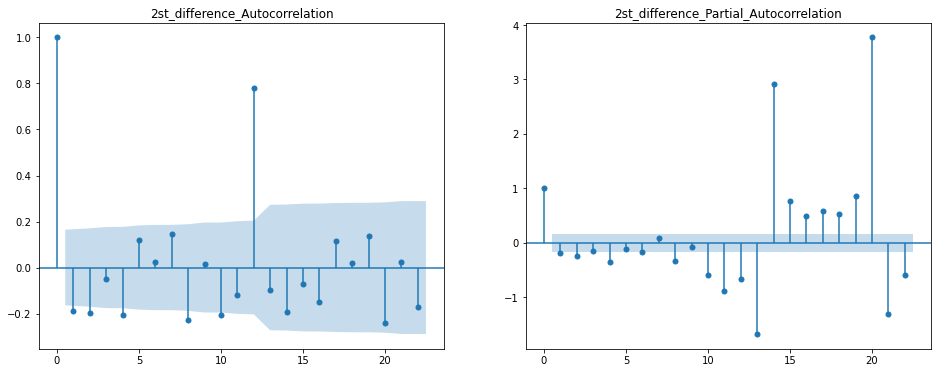

In [30]:
acf=(data['2st_difference'].dropna(axis=0))
pacf=(data['2st_difference'].dropna(axis=0))

fig, ax= plt.subplots(1,2,figsize=(16,6))
plot_acf(acf,ax=ax[0])
ax[0].set_title('2st_difference_Autocorrelation')
plot_pacf(pacf,ax=ax[1])
ax[1].set_title('2st_difference_Partial_Autocorrelation')


Text(0.5, 1.0, '12_difference_Partial_Autocorrelation')

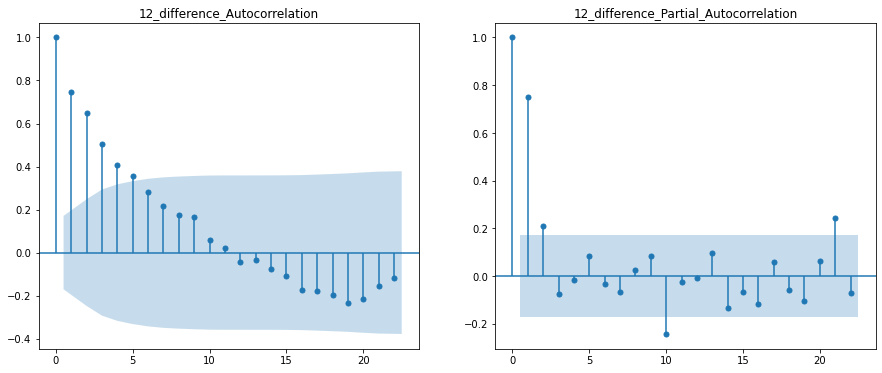

In [31]:
acf=(data['12_Difference'].dropna(axis=0))
pacf=(data['12_Difference'].dropna(axis=0))
fig,ax= plt.subplots(1,2,figsize=(15,6))

plot_acf(acf,ax=ax[0])
ax[0].set_title('12_difference_Autocorrelation')

plot_pacf(pacf,ax=ax[1])
ax[1].set_title('12_difference_Partial_Autocorrelation')


## Splitting into Trainnig and Testing

In [32]:
n=int(len(data)*0.8)
n

115

In [33]:
train=data['Thousands of Passengers'][:n]
test=data['Thousands of Passengers'][n:]
print(train.shape)
print(test.shape)

(115,)
(29,)


## SARIMA Model

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_sarima=SARIMAX(train,order=(5,0,2),seasonal_order=(0,2,0,12))
model_sarima.fit=model_sarima.fit()
model_sarima.fit.summary()

D:\New folder\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:             Thousands of Passengers   No. Observations:                  115
Model:             SARIMAX(5, 0, 2)x(0, 2, [], 12)   Log Likelihood                -361.363
Date:                             Sun, 10 Jul 2022   AIC                            738.725
Time:                                     19:35:48   BIC                            758.812
Sample:                                          0   HQIC                           746.829
                                             - 115                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7288      0.111      6.538      0.000       0.510       0.947
ar.L2         -0.5829      0.158     -3.690      0.000      -0.893      -0.273
ar.L3          0.1756      0.180      0.978      0.328      -0.176       0.528
ar.L4          0.4029      0.160      2.521      0.012       0.090       0.716
ar.L5         -0.0530      0.148     -0.358      0.720      -0.344       0.237
ma.L1         -0.1071      0.074     -1.453      0.146      -0.251       0.037
ma.L2          0.9835      0.305      3.224      0.001       0.386       1.581
sigma2       152.4094     48.387      3.150      0.002      57.573     247.246
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.20
Prob(Q):                              0.92   Prob(JB):                         0.33
Heteroskedasticity (H):               0.45   Skew:                             0.26
Prob(H) (two-sided):                  0.03   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [35]:
train.index[-1]

114

In [36]:
test.index[-1]

143

In [37]:
pred_Sarima=model_sarima.fit.predict(start=test.index[0],end=test.index[-1])
residuals=test-pred_Sarima

In [38]:
pred_Sarima.head()

115    500.444586
116    431.011390
117    371.492703
118    326.154907
119    352.274654
Name: predicted_mean, dtype: float64

<AxesSubplot:>

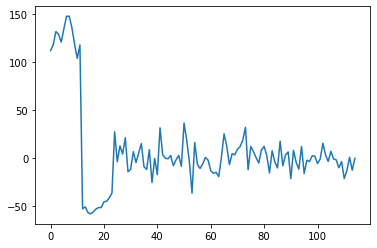

In [39]:
model_sarima.fit.resid.plot()

<AxesSubplot:ylabel='Density'>

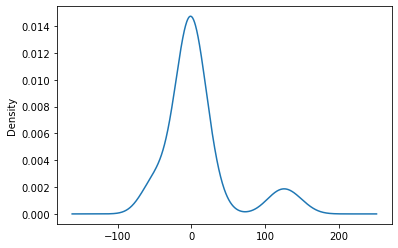

In [40]:
model_sarima.fit.resid.plot(kind='kde')

In [41]:
test['Predicted_SARIMA']=pred_Sarima
pred_Sarima

115    500.444586
116    431.011390
117    371.492703
118    326.154907
119    352.274654
120    352.242068
121    325.963422
122    362.141722
123    341.909613
124    363.977577
125    442.439752
126    514.091086
127    531.634367
128    454.592622
129    392.421472
130    345.439083
131    367.907064
132    363.218400
133    331.796331
134    360.791171
135    335.591876
136    364.809379
137    448.852515
138    535.990547
139    562.516352
140    478.417190
141    413.091721
142    363.913322
143    383.081833
Name: predicted_mean, dtype: float64

In [42]:
test.head()

115    505.0
116    404.0
117    359.0
118    310.0
119    337.0
Name: Thousands of Passengers, dtype: object

In [43]:
test_data=data['Thousands of Passengers'][n:]
test_data=test_data.to_frame()

In [44]:
test_data['pred_Sarima']=pred_Sarima
len(test_data)

29

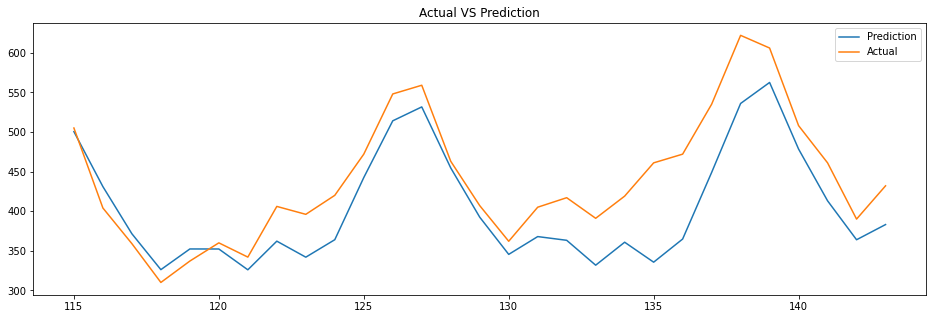

In [45]:
test_data['pred_Sarima'].plot(figsize=(16,5),label='Prediction')
test_data['Thousands of Passengers'].plot(figsize=(16,5),label='Actual')
plt.title('Actual VS Prediction')
plt.legend()